In [1]:
# Load dictionary
# Need model definition, right?
import torch.nn as nn
from baukit import Trace
from einops import rearrange
import torch
import sys
sys.path.append('/root/sparse-autoencoders/')
from functools import partial
from src.autoencoders.autoencoder import UntiedSAE

/root/log/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def zero_k_lowest_nonzero(arr, k):
    abs_arr = arr.abs()
    # Set zeros to +inf to ignore them in topk (since we are now looking for lowest values)
    mask = torch.where(abs_arr > 0, abs_arr, torch.tensor(float('inf'), device=arr.device))
    # Get top k lowest values; since torch.topk only finds the largest, we use -mask
    _, indices = torch.topk(-mask, k, dim=1)
    # Create a range for the batch dimension
    batch_indices = torch.arange(arr.size(0), device=arr.device).unsqueeze(1)
    # Use advanced indexing to set the k-lowest nonzero elements to 0
    arr[batch_indices, indices] = 0
    return arr
       
def compute_loss(inputs_ids, logits, reduction='mean'):
    return torch.nn.CrossEntropyLoss(reduction=reduction)(
        logits[:,:-1,:].reshape(-1, logits.shape[-1]),
        inputs_ids[:,1:].reshape(-1)
    ).item()

def dict_ablation_fn_below_threshold(representation, name, other_value, thresholds):
    # print(f"representation {representation}")
    if(isinstance(representation, tuple)):
        second_value = representation[1]
        internal_activation = representation[0]
    else:
        internal_activation = representation
    int_val = rearrange(internal_activation, "b seq d_model -> (b seq) d_model")
    features = sae.encode(int_val)

    # Create a mask where values in 'features_list' are greater than or equal to 'thresholds'
    mask = features >= thresholds.to(features.device)
    # Apply the mask to 'features_list', setting values below 'thresholds' to 0
    features_list = features * mask

    reconstruction = sae.decode(features_list)
        
    batch, seq_len, hidden_size = internal_activation.shape
    reconstruction = rearrange(reconstruction, '(b s) h -> b s h', b=batch, s=seq_len)

    if(isinstance(representation, tuple)):
        return_value = (reconstruction, second_value)
    else:
        return_value = reconstruction

    return return_value

def calc_MSE_with_ablations(first_n_batches, total_k, model, sae, activation_name, thresholds, average=True):
    if(average):
        avg_MSE = torch.zeros(total_k)
        avg_L0 = torch.zeros(total_k)
        avg_cos_sim = torch.zeros(total_k)
        avg_l2_ratio = torch.zeros(total_k)
    else:
        batch_size, seq_pos = first_n_batches[0]["input_ids"].shape
        tokens_per_batch = batch_size*seq_pos
        num_batches = len(first_n_batches)
        avg_MSE = torch.zeros(total_k, num_batches*batch_size, seq_pos)
        avg_L0 = torch.zeros(total_k, num_batches*batch_size, seq_pos)
        avg_cos_sim = torch.zeros(total_k, num_batches*batch_size, seq_pos)
        avg_l2_ratio = torch.zeros(total_k, num_batches*batch_size, seq_pos)
    original_L0 = 0
    with torch.no_grad():
        for ind_batch, batch in enumerate(first_n_batches):
            input_ids = batch["input_ids"].to(device)
            with Trace(model, activation_name) as ret:
                _ = model(input_ids).logits
                #Calculate MSE
            representation = ret.output
            if(isinstance(representation, tuple)):
                representation = representation[0]
            activation = rearrange(representation, "b seq d_model -> (b seq) d_model")
            features = sae.encode(activation)
            
            original_L0 += features.norm(0, dim=-1).mean().item()
            original_norm = activation.norm(2, dim=-1)
            if(average):
                original_norm = original_norm.mean().item()
            for k_inc in range(total_k):
                # Set features to zero below threshold
                threshold = thresholds[k_inc]
                mask = features >= threshold.to(features.device)
                features_list = features * mask

                #Pass new features through decoder
                reconstruction = sae.decode(features_list)

                # Calculate MSE
                if(average):
                    MSE = torch.nn.MSELoss()(reconstruction, activation).item()
                    avg_MSE[k_inc] += MSE
    
                    cos_sim = torch.nn.CosineSimilarity(dim=1)(reconstruction, activation).mean().item()
                    avg_cos_sim[k_inc] += cos_sim
    
                    norm = reconstruction.norm(2, dim=-1).mean().item()
                    avg_l2_ratio[k_inc] += norm/original_norm

                    avg_L0[k_inc] += features_list.norm(0, dim=-1).mean().item()
                else:
                    # return reconstruction, activation, features_list, features, mask
                    MSE = torch.nn.MSELoss(reduction='none')(reconstruction, activation).mean(-1)
                    avg_MSE[k_inc, ind_batch*batch_size:(ind_batch+1)*batch_size, :] = rearrange(MSE, "(b s) -> b s", b=batch_size, s=seq_pos)
                    cos_sim = torch.nn.CosineSimilarity(dim=1)(reconstruction, activation)
                    avg_cos_sim[k_inc, ind_batch*batch_size:(ind_batch+1)*batch_size, :] = rearrange(cos_sim, "(b s) -> b s", b=batch_size, s=seq_pos)
                    norm = reconstruction.norm(2, dim=-1)
                    avg_l2_ratio[k_inc, ind_batch*batch_size:(ind_batch+1)*batch_size, :] = rearrange(norm/original_norm, "(b s) -> b s", b=batch_size, s=seq_pos)
                    avg_L0[k_inc, ind_batch*batch_size:(ind_batch+1)*batch_size, :] = rearrange(features_list.norm(0, dim=-1), "(b s) -> b s", b=batch_size, s=seq_pos)
    if(average):
        avg_MSE /= N
        avg_L0 /= N
        avg_cos_sim /= N
        avg_l2_ratio /= N
    original_L0 /= N
    return avg_MSE, avg_L0, avg_cos_sim, avg_l2_ratio, original_L0

def calc_CE_with_ablations(first_n_batches, total_k, model, sae, activation_name, dict_ablation_function, thresholds):
    avg_CE = torch.zeros(total_k)
    original_CE = 0
    with torch.no_grad():
        for ind_batch, batch in enumerate(first_n_batches):
            input_ids = batch["input_ids"].to(device)
            for k_inc in range(total_k):
                hook_function = partial(dict_ablation_function, thresholds=thresholds[k_inc])
                with Trace(model, activation_name, edit_output = hook_function) as ret:
                    #Calculate CE
                    logits = model(input_ids).logits
                    CE = compute_loss(input_ids, logits)
                    avg_CE[k_inc] += CE
            original_logits = model(input_ids).logits
            original_CE += compute_loss(input_ids, original_logits)
                
    avg_CE /= N
    original_CE /= N
    return avg_CE, original_CE

In [70]:
sae_folder_location

'/root/.cache/huggingface/hub/models--jbrinkma--sae-l1-sweep/snapshots/6124e1ffa6bab1e4ec29c0a289c60c56e67b4568'

In [75]:
from huggingface_hub import snapshot_download
# repo_id = "jbrinkma/sae-l1-comp"
repo_id = "jbrinkma/sae-l1-sweep"

sae_folder_location = snapshot_download(repo_id=repo_id,  allow_patterns="*.pt")
import os

# Load all .pt files from the sae_folder_location
all_saes = []
l1s = []
for file in os.listdir(sae_folder_location):
    if file.endswith(".pt"):
        l1s.append(file.split('_')[2])
        path = os.path.join(sae_folder_location, file)
        all_saes.append(torch.load(path))
activation_size, dict_size = all_saes[0].W_d.shape

Fetching 11 files: 100%|██████████| 11/11 [00:00<00:00, 11897.20it/s]


In [76]:
from huggingface_hub import snapshot_download
repo_id = "jbrinkma/sae-l1-comp"
# repo_id = "jbrinkma/sae-l1-sweep"

sae_folder_location = snapshot_download(repo_id=repo_id,  allow_patterns="*.pt")
import os

# Load all .pt files from the sae_folder_location
all_saes_sqrt = []
l1s_sqrt = []
for file in os.listdir(sae_folder_location):
    if file.endswith(".pt"):
        l1s_sqrt.append(file.split('_')[2])
        path = os.path.join(sae_folder_location, file)
        all_saes_sqrt.append(torch.load(path))
activation_size, dict_size = all_saes_sqrt[0].W_d.shape

Fetching 11 files: 100%|██████████| 11/11 [00:00<00:00, 47515.29it/s]


In [31]:
# Load data
from src.training.utils import chunk_and_tokenize, load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import DataLoader

model_name = "EleutherAI/pythia-70m-deduped"
dataset_name = "Elriggs/openwebtext-100k"

layer = 3
activation_name = f"gpt_neox.layers.{layer}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download the model and tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the dataset
batch_size = 16
context_length = 256
dataset = load_dataset(dataset_name, split="train")
token_dataset, _ = chunk_and_tokenize(dataset, tokenizer, max_length=context_length)
train_loader = DataLoader(token_dataset, batch_size=batch_size, shuffle=True)

# Freeze the model & dictionary
model.eval()
model.requires_grad_(False)
# sae.requires_grad_(False)
all_saes = [sae.requires_grad_(False) for sae in all_saes]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [77]:
# Grab the first N batches of dataloader
N = 10
first_n_batches = []
for i, batch in enumerate(train_loader):
    if i >= N:
        break
    first_n_batches.append(batch)

In [78]:
total_linspace = 25
all_linear_scalings = torch.linspace(0, 3, total_linspace).repeat(dict_size, 1).to(device).T
num_saes = len(all_saes)
all_l1_original_CE = torch.zeros(num_saes, total_linspace)
all_l1_original_MSE = torch.zeros(num_saes, total_linspace)
all_l1_original_cos_sim = torch.zeros(num_saes, total_linspace)
all_l1_original_l2_ratio = torch.zeros(num_saes, total_linspace)
all_l1_original_L0 = torch.zeros(num_saes, total_linspace)
for ind_sae, sae in enumerate(all_saes):
    avg_CE_linear, original_CE = calc_CE_with_ablations(first_n_batches, total_linspace, model, sae, activation_name, dict_ablation_fn_below_threshold, all_linear_scalings)
    avg_MSE_linear, avg_L0_linear, avg_cos_sim, avg_l2_ratio, original_L0 = calc_MSE_with_ablations(first_n_batches, total_linspace, model, sae, activation_name, all_linear_scalings)
    all_l1_original_CE[ind_sae] = avg_CE_linear
    all_l1_original_MSE[ind_sae] = avg_MSE_linear
    all_l1_original_L0[ind_sae] = avg_L0_linear
    all_l1_original_cos_sim[ind_sae] = avg_cos_sim
    all_l1_original_l2_ratio[ind_sae] = avg_l2_ratio

In [79]:
total_linspace = 25
all_linear_scalings = torch.linspace(0, 3, total_linspace).repeat(dict_size, 1).to(device).T
num_saes = len(all_saes_sqrt)
all_sqrt_CE = torch.zeros(num_saes, total_linspace)
all_sqrt_MSE = torch.zeros(num_saes, total_linspace)
all_sqrt_cos_sim = torch.zeros(num_saes, total_linspace)
all_sqrt_l2_ratio = torch.zeros(num_saes, total_linspace)
all_sqrt_L0 = torch.zeros(num_saes, total_linspace)
for ind_sae, sae in enumerate(all_saes_sqrt):
    avg_CE_linear, original_CE = calc_CE_with_ablations(first_n_batches, total_linspace, model, sae, activation_name, dict_ablation_fn_below_threshold, all_linear_scalings)
    avg_MSE_linear, avg_L0_linear, avg_cos_sim, avg_l2_ratio, original_L0 = calc_MSE_with_ablations(first_n_batches, total_linspace, model, sae, activation_name, all_linear_scalings)
    all_sqrt_CE[ind_sae] = avg_CE_linear
    all_sqrt_MSE[ind_sae] = avg_MSE_linear
    all_sqrt_L0[ind_sae] = avg_L0_linear
    all_sqrt_cos_sim[ind_sae] = avg_cos_sim
    all_sqrt_l2_ratio[ind_sae] = avg_l2_ratio

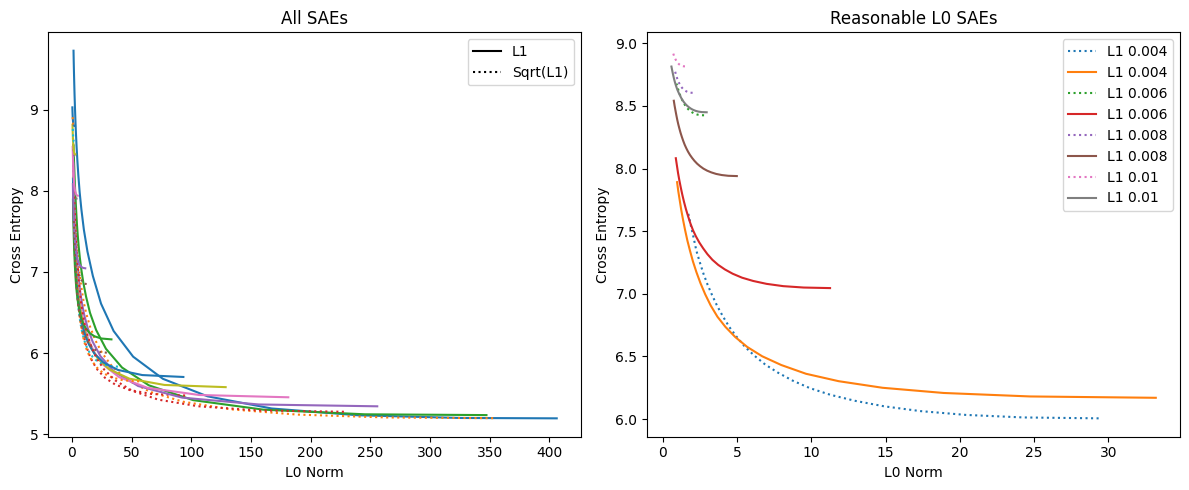

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'num_saes', 'all_L0', 'all_CE', and 'rounded_numbers' are defined
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create 1 row, 2 columns of subplots
num_saes = len(all_saes)
# Plot for all saes
for i in range(num_saes):
    # Plot all_sqrt_l1_original_L0 as dotted
    axs[0].plot(all_l1_original_L0[i], all_l1_original_CE[i])
    axs[0].plot(all_sqrt_L0[i], all_sqrt_CE[i], linestyle='dotted')
# Set dotted label as "Sqrt(L1)"
axs[0].plot([], [],  label='L1', color = 'black')
axs[0].plot([], [], linestyle='dotted', label='Sqrt(L1)', color = 'black')
# Set norm
axs[0].set_xlabel("L0 Norm")
axs[0].set_ylabel("Cross Entropy")
axs[0].set_title("All SAEs")
axs[0].legend()

# Plot for saes starting from 5
for i in range(7, num_saes):
# for i in range(0,6):
    axs[1].plot(all_sqrt_L0[i], all_sqrt_CE[i], label=f"L1 {l1s[i]}", linestyle='dotted')
    axs[1].plot(all_l1_original_L0[i-1], all_l1_original_CE[i-1], label=f"L1 {l1s[i]}")

axs[1].set_xlabel("L0 Norm")
axs[1].set_ylabel("Cross Entropy")
axs[1].set_title("Reasonable L0 SAEs")
axs[1].legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [61]:
l1s

['0.0001',
 '0.0002',
 '0.0004',
 '0.0006',
 '0.0008',
 '0.001',
 '0.002',
 '0.004',
 '0.006',
 '0.008',
 '0.01']

In [28]:
all_L0[7], all_CE[7]

(tensor([29.4123, 24.3070, 20.4228, 17.3753, 14.9511, 12.9726, 11.3397,  9.9666,
          8.8113,  7.8337,  6.9813,  6.2458,  5.6036,  5.0446,  4.5423,  4.1000,
          3.7141,  3.3698,  3.0522,  2.7751,  2.5161,  2.2869,  2.0834,  1.9039,
          1.7425]),
 tensor([5.7351, 5.7428, 5.7631, 5.7944, 5.8295, 5.8725, 5.9198, 5.9742, 6.0301,
         6.0937, 6.1552, 6.2201, 6.2926, 6.3700, 6.4490, 6.5323, 6.6119, 6.7016,
         6.7876, 6.8753, 6.9670, 7.0653, 7.1551, 7.2395, 7.3482]))

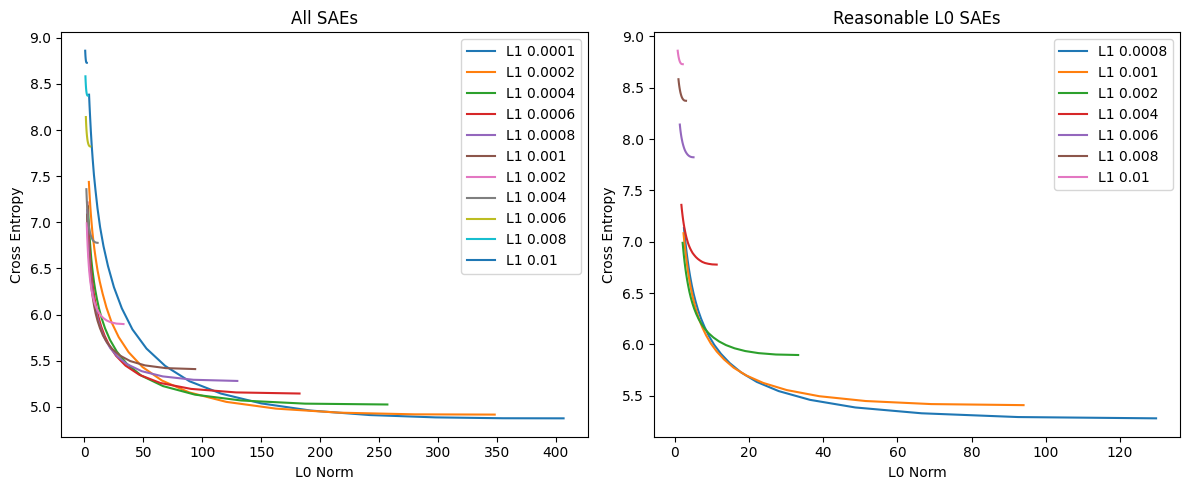

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'num_saes', 'all_L0', 'all_CE', and 'rounded_numbers' are defined
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create 1 row, 2 columns of subplots

# Plot for all saes
for i in range(num_saes):
    axs[0].plot(all_L0[i], all_CE[i], label=f"L1 {l1s[i]}")
axs[0].set_xlabel("L0 Norm")
axs[0].set_ylabel("Cross Entropy")
axs[0].set_title("All SAEs")
axs[0].legend()

# Plot for saes starting from 5
for i in range(4, num_saes):
    axs[1].plot(all_L0[i], all_CE[i], label=f"L1 {l1s[i]}")
axs[1].set_xlabel("L0 Norm")
axs[1].set_ylabel("Cross Entropy")
axs[1].set_title("Reasonable L0 SAEs")
axs[1].legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


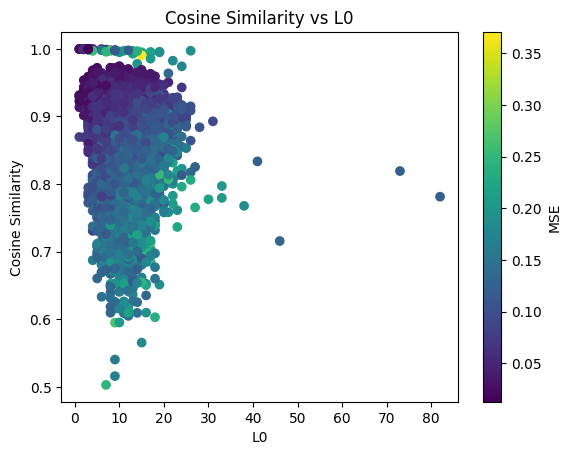

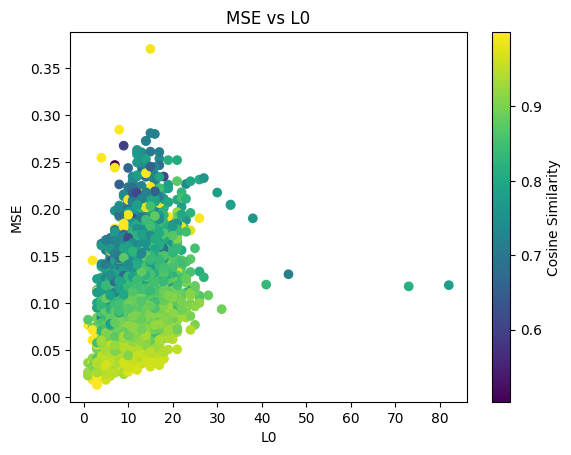

In [121]:
# scatter plot of mse vs l0
import matplotlib.pyplot as plt
def plot_two_metrics(x, y, z, x_label, y_label, z_label, title):
    k_ind = 0
    plt.figure()
    x_plot = x.flatten(-2)[k_ind].cpu().numpy()
    y_plot = y.flatten(-2)[k_ind].cpu().numpy()
    z_val = z.flatten(-2)[k_ind].cpu().numpy()
    # plt.scatter(x_plot, y_plot)
    # plot z as color
    plt.scatter(x_plot, y_plot, c=z_val, cmap='viridis')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # Label colorbar as MSE
    cbar = plt.colorbar()
    cbar.set_label(z_label)
    plt.show()
# plot_two_metrics(l2_ratio, cos_sim, MSE_linear, "L2 Ratio", "Cosine Similarity", "MSE", "Cosine Similarity vs L2 ratio")
# plot_two_metrics(l2_ratio, MSE_linear, cos_sim, "L2 Ratio", "MSE", "Cosine Similarity", "MSE vs L2 ratio")
plot_two_metrics(L0_linear, cos_sim, MSE_linear, "L0", "Cosine Similarity", "MSE", "Cosine Similarity vs L0")
plot_two_metrics(L0_linear, MSE_linear, cos_sim, "L0", "MSE", "Cosine Similarity", "MSE vs L0")

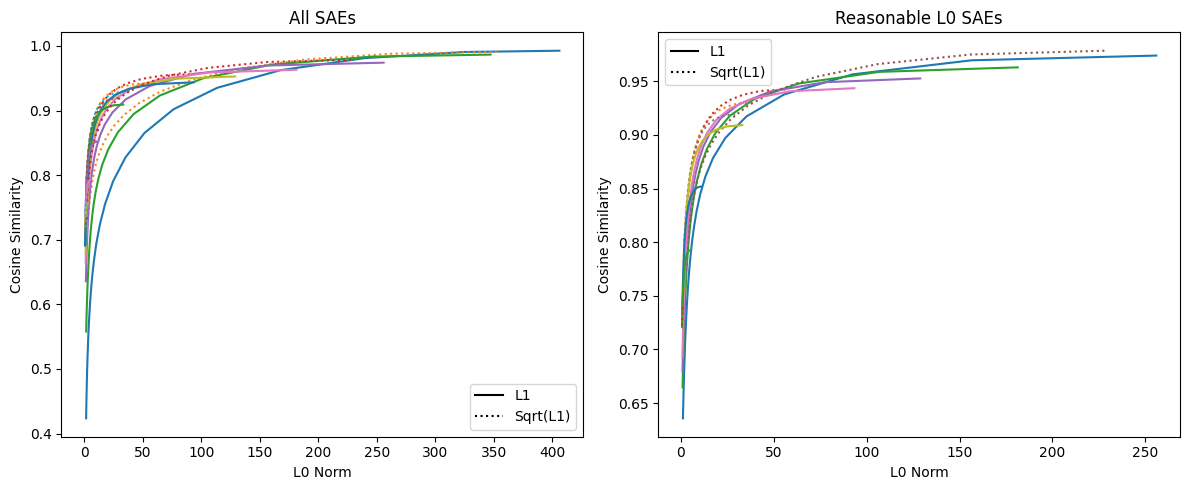

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'num_saes', 'all_L0', 'all_cos_sim', and 'rounded_numbers' are defined
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create 1 row, 2 columns of subplots

# Plot for all saes
for i in range(num_saes):
    # Plot all_sqrt_l1_original_L0 as dotted
    axs[0].plot(all_l1_original_L0[i], all_l1_original_cos_sim[i])
    axs[0].plot(all_sqrt_L0[i], all_sqrt_cos_sim[i], linestyle='dotted')
# Set dotted label as "Sqrt(L1)"
axs[0].plot([], [],  label='L1', color = 'black')
axs[0].plot([], [], linestyle='dotted', label='Sqrt(L1)', color = 'black')
    
axs[0].set_xlabel("L0 Norm")
axs[0].set_ylabel("Cosine Similarity")
axs[0].set_title("All SAEs")
axs[0].legend()

# Plot for saes starting from 5
for i in range(4, num_saes):
    axs[1].plot(all_l1_original_L0[i-2], all_l1_original_cos_sim[i-2])
    axs[1].plot(all_sqrt_L0[i], all_sqrt_cos_sim[i], linestyle='dotted')

axs[1].plot([], [],  label='L1', color = 'black')
axs[1].plot([], [], linestyle='dotted', label='Sqrt(L1)', color = 'black')
axs[1].set_xlabel("L0 Norm")
axs[1].set_ylabel("Cosine Similarity")
axs[1].set_title("Reasonable L0 SAEs")
axs[1].legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


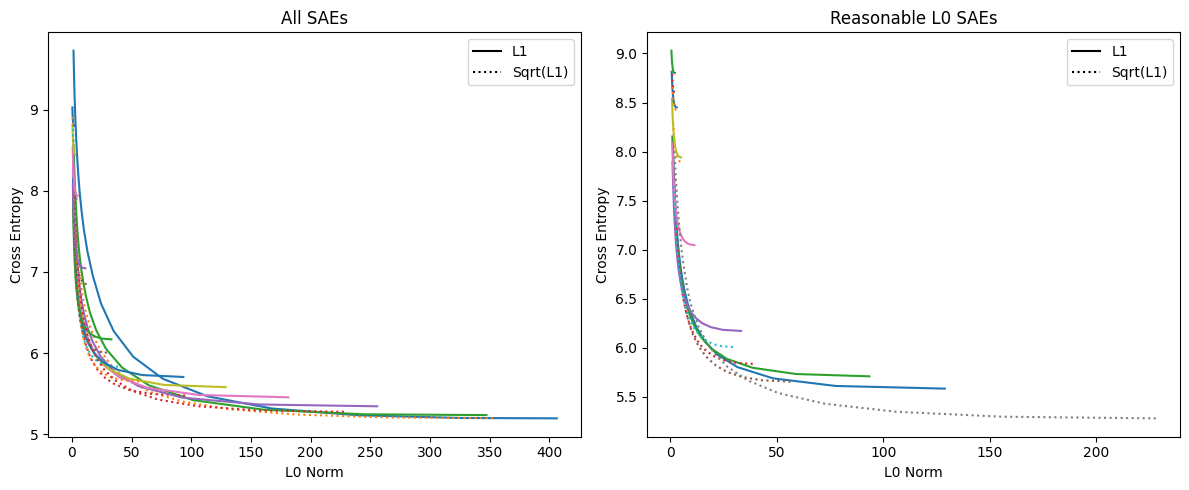

In [101]:
plot_two_subplots_smaller_SAE(all_l1_original_L0, all_l1_original_CE, all_sqrt_L0, all_sqrt_CE, "L0 Norm", "Cross Entropy", "L1", "Sqrt(L1)", 4)

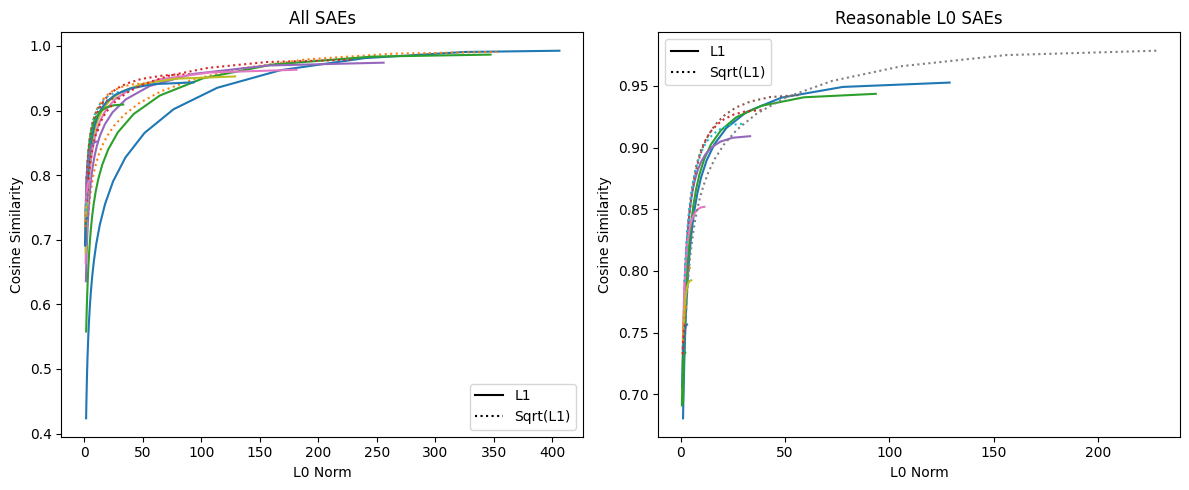

In [100]:
import matplotlib.pyplot as plt
import numpy as np
def plot_two_subplots_smaller_SAE(x, y, x2, y2, global_x_label, global_y_label, x_label, x2_label, smaller_SAE_num = 4):
    # Assuming 'num_saes', 'x', 'all_cos_sim', and 'rounded_numbers' are defined
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create 1 row, 2 columns of subplots

    # Plot for all saes
    for i in range(num_saes):
        axs[0].plot(x[i], y[i])
        # Plot all_l1_original_L0 as dotted
        axs[0].plot(x2[i], y2[i], linestyle='dotted')
    # Set dotted label as "Sqrt(L1)"
    axs[0].plot([], [],  label=x_label, color = "black")
    axs[0].plot([], [], linestyle='dotted', label=x2_label, color = 'black')
    axs[0].set_xlabel(global_x_label)
    axs[0].set_ylabel(global_y_label)
    axs[0].set_title("All SAEs")
    axs[0].legend()

    # Plot for saes starting from 5
    for i in range(smaller_SAE_num, num_saes):
        axs[1].plot(x[i], y[i])
        axs[1].plot(x2[i-1], y2[i-1], linestyle='dotted')

    axs[1].plot([], [],  label=x_label, color = "black")
    axs[1].plot([], [], linestyle='dotted', label=x2_label, color = 'black')

    axs[1].set_xlabel(global_x_label)
    axs[1].set_ylabel(global_y_label)
    axs[1].set_title("Reasonable L0 SAEs")
    axs[1].legend()

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

plot_two_subplots_smaller_SAE(all_l1_original_L0, all_l1_original_cos_sim, all_sqrt_L0, all_sqrt_cos_sim, "L0 Norm", "Cosine Similarity", "L1", "Sqrt(L1)", 4)

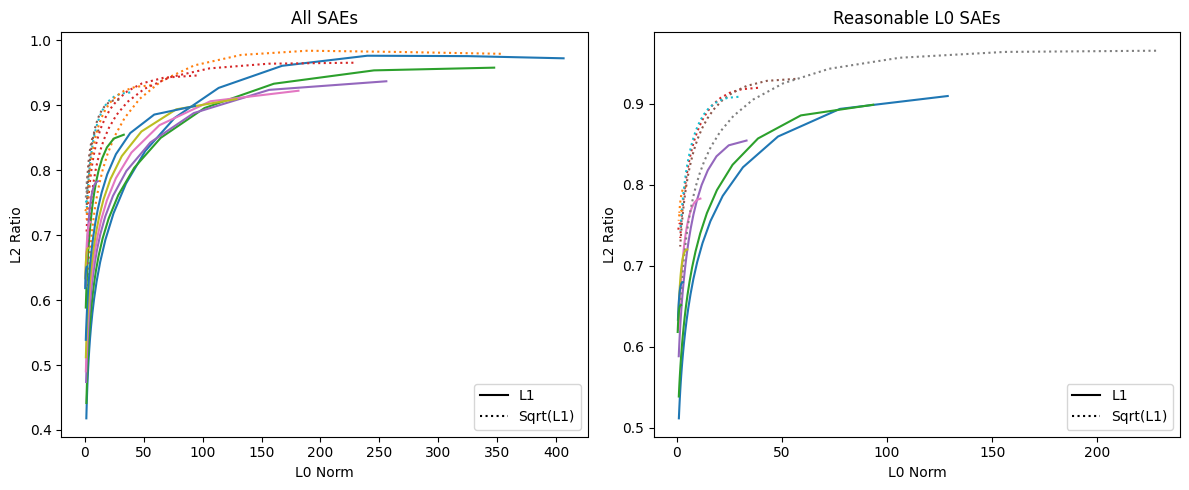

In [102]:
plot_two_subplots_smaller_SAE(all_l1_original_L0, all_l1_original_l2_ratio, all_sqrt_L0, all_sqrt_l2_ratio, "L0 Norm", "L2 Ratio", "L1", "Sqrt(L1)", 4)


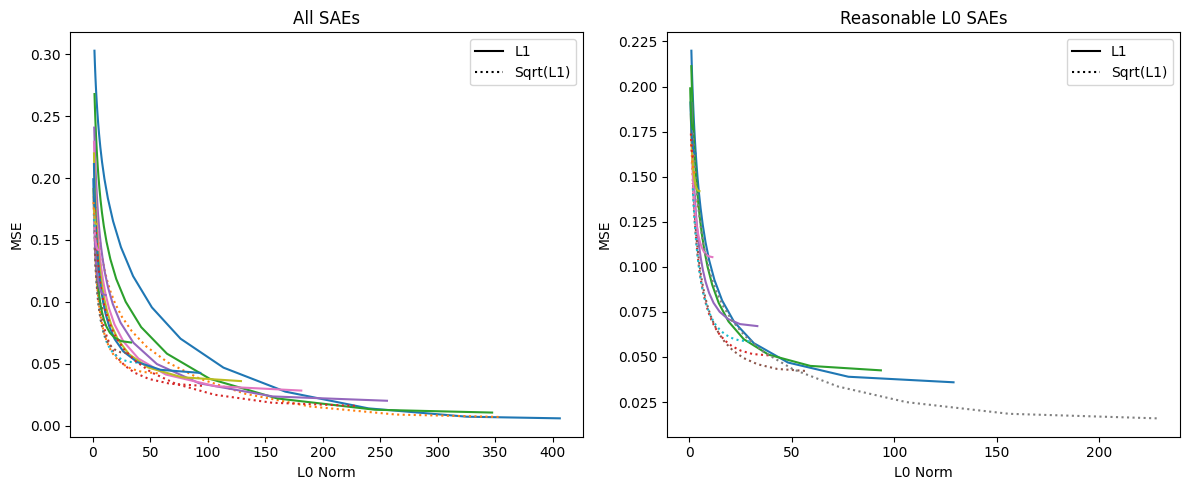

In [103]:
plot_two_subplots_smaller_SAE(all_l1_original_L0, all_l1_original_MSE, all_sqrt_L0, all_sqrt_MSE, "L0 Norm", "MSE", "L1", "Sqrt(L1)", 4)


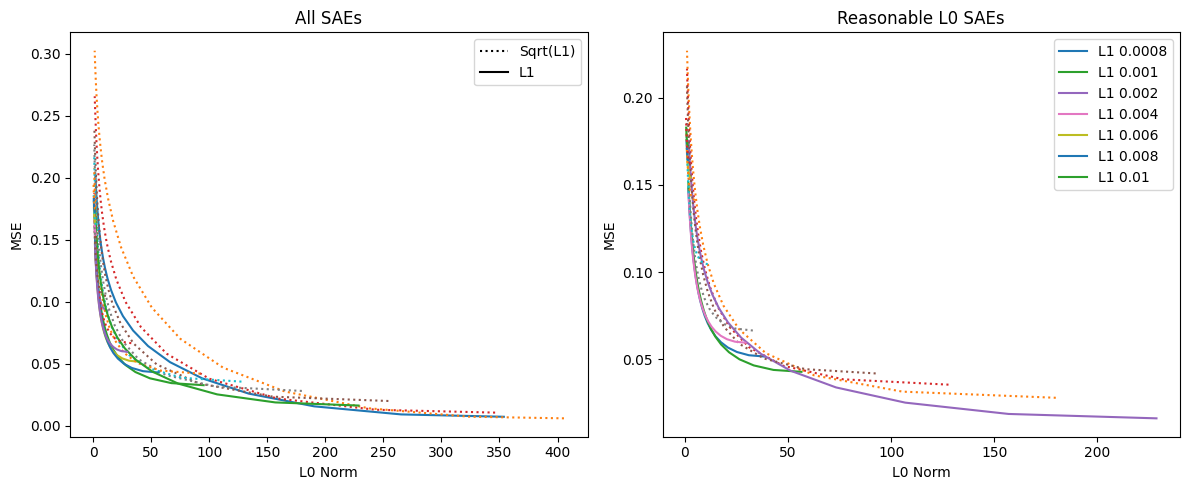

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'num_saes', 'all_L0', 'all_cos_sim', and 'rounded_numbers' are defined
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create 1 row, 2 columns of subplots

# Plot for all saes
for i in range(num_saes):
    axs[0].plot(all_L0[i], all_MSE[i])
    # Plot all_l1_original_L0 as dotted
    axs[0].plot(all_l1_original_L0[i], all_l1_original_MSE[i], linestyle='dotted')
# Set dotted label as "Sqrt(L1)"
axs[0].plot([], [], linestyle='dotted', label='Sqrt(L1)', color = 'black')
axs[0].plot([], [],  label='L1', color = 'black')
axs[0].set_xlabel("L0 Norm")
axs[0].set_ylabel("MSE")
axs[0].set_title("All SAEs")
axs[0].legend()

# Plot for saes starting from 5
for i in range(4, num_saes):
    axs[1].plot(all_L0[i], all_MSE[i], label=f"L1 {rounded_numbers[i]}")
    axs[1].plot(all_l1_original_L0[i-1], all_l1_original_MSE[i-1], linestyle='dotted')

axs[1].set_xlabel("L0 Norm")
axs[1].set_ylabel("MSE")
axs[1].set_title("Reasonable L0 SAEs")
axs[1].legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [21]:
sae = all_saes[7]
total_k = 20
avg_CE = torch.zeros(total_k)
original_CE = 0
with torch.no_grad():
    for ind_batch, batch in enumerate(first_n_batches):
        input_ids = batch["input_ids"].to(device)
        for k_inc in range(total_k):
            # k_inc = 0
            hook_function = partial(dict_ablation_fn_k, k=k_inc)
            with Trace(model, activation_name, edit_output = hook_function) as ret:
                #Calculate CE
                logits = model(input_ids).logits
                CE = compute_loss(input_ids, logits)
                avg_CE[k_inc] += CE
        original_logits = model(input_ids).logits
        original_CE += compute_loss(input_ids, original_logits)
            
avg_CE /= N
original_CE /= N
print(avg_CE)
print(original_CE)

NameError: name 'dict_ablation_fn_k' is not defined

In [23]:
d_model, n_features = sae.W_d.shape
tokens_per_batch = batch_size * context_length
all_features = torch.zeros(tokens_per_batch*N, n_features)
avg_L0 = torch.zeros(total_k)

avg_MSE = torch.zeros(total_k)
with torch.no_grad():
    for ind_batch, batch in enumerate(first_n_batches):
        input_ids = batch["input_ids"].to(device)
        for k_inc in range(total_k):
            # k_inc = 0
            with Trace(model, activation_name) as ret:
                #Calculate CE
                _ = model(input_ids).logits
                #Calculate MSE
                representation = ret.output
                if(isinstance(representation, tuple)):
                    representation = representation[0]
                activation = rearrange(representation, "b seq d_model -> (b seq) d_model")
                features = sae.encode(activation)
                all_features[ind_batch*tokens_per_batch:(ind_batch+1)*tokens_per_batch] = features.cpu().clone()
                features = zero_k_lowest_nonzero(features, k_inc)
                reconstruction = sae.decode(features)
                MSE = torch.nn.MSELoss()(reconstruction, activation).item()
                # print k, mse, ce
                avg_MSE[k_inc] += MSE

                #L0
                avg_L0[k_inc] += features.norm(0, dim=-1).mean().item()
avg_MSE /= N
avg_L0 /= N
print(avg_MSE)
print(avg_L0)

tensor([0.1069, 0.1225, 0.2040, 0.3504, 0.3824, 0.3994, 0.4173, 0.4389, 0.4602,
        0.4832, 0.5115, 0.5379, 0.5610, 0.5807, 0.5960, 0.6082, 0.6172, 0.6231,
        0.6266, 0.6298])
tensor([11.2529, 10.2529,  9.2533,  8.2563,  7.2661,  6.2886,  5.3357,  4.4245,
         3.5767,  2.8104,  2.1425,  1.5818,  1.1315,  0.7846,  0.5292,  0.3490,
         0.2262,  0.1449,  0.0936,  0.0614])


In [25]:
print(all_features.shape)

torch.Size([81920, 2048])


In [24]:
# Get the values for quantiles & percentage of max activation
total_thresholds = 20
max_values = all_features.max(dim=0).values
all_percentages = [torch.linspace(0, 2, total_thresholds)*max_val for max_val in max_values]
all_linear_scalings = [torch.linspace(0, 2, total_thresholds) for max_val in max_values]
# all_quantiles = [torch.quantile(all_features, q=q, dim=0) for q in torch.linspace(0,1,total_thresholds)]
all_percentages = torch.stack(all_percentages).T
all_linear_scalings = torch.stack(all_linear_scalings).T
# all_quantiles = torch.stack(all_quantiles)

In [26]:
from tqdm import tqdm
all_quantiles = torch.zeros(total_thresholds, n_features)
for i in tqdm(range(n_features)):
    feature = all_features[:, i]
    nonzero_row = feature[feature != 0]
    if(len(nonzero_row) == 0):
        continue
    quantiles = torch.quantile(nonzero_row, q=torch.linspace(0, 1, total_thresholds))
    all_quantiles[:, i] = quantiles

100%|██████████| 2048/2048 [00:15<00:00, 129.25it/s]


In [28]:
total_k = total_thresholds
avg_CE_percentage, original_CE = calc_CE_with_ablations(first_n_batches, total_k, model, sae, activation_name, dict_ablation_fn_below_threshold, all_percentages)
avg_MSE_percentage, avg_L0_percentage, avg_cos_sim_percentage, avg_l2_ratio_percentage, original_L0 = calc_MSE_with_ablations(first_n_batches, total_k, model, sae,  activation_name, all_percentages)

avg_CE_quantile, _ = calc_CE_with_ablations(first_n_batches, total_k, model, sae,  activation_name, dict_ablation_fn_below_threshold, all_quantiles)
avg_MSE_quantile, avg_L0_quantile, avg_cos_sim_quantile, avg_l2_ratio_quantile,  original_L0 = calc_MSE_with_ablations(first_n_batches, total_k, model, sae,  activation_name, all_quantiles)

avg_CE_linear, _ = calc_CE_with_ablations(first_n_batches, total_k, model, sae,  activation_name, dict_ablation_fn_below_threshold, all_linear_scalings)
avg_MSE_linear, avg_L0_linear, avg_cos_sim_linear, avg_l2_ratio_linear,  _ = calc_MSE_with_ablations(first_n_batches, total_k, model, sae,  activation_name, all_linear_scalings)

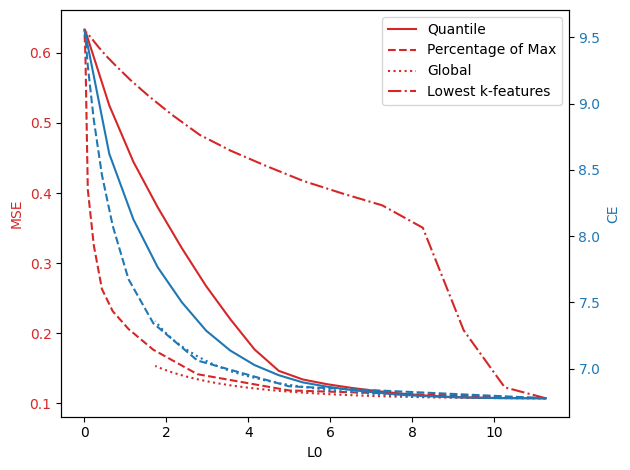

In [41]:
# Same for quantiles
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('L0')
ax1.set_ylabel('MSE', color=color)
ax1.plot(avg_L0_quantile, avg_MSE_quantile, color=color, label="Quantile")
ax1.plot(avg_L0_percentage, avg_MSE_percentage, color=color, linestyle='dashed', label="Percentage of Max")
ax1.plot(avg_L0_linear, avg_MSE_linear, color=color, linestyle='dotted', label="Global")
ax1.plot(avg_L0, avg_MSE, color=color, linestyle='dashdot', label="Lowest k-features")
ax1.tick_params(axis='y', labelcolor=color)
plt.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('CE', color=color)  # we already handled the x-label with ax1
ax2.plot(avg_L0_quantile, avg_CE_quantile, color=color, label="Quantile")
ax2.plot(avg_L0_percentage, avg_CE_percentage, color=color, linestyle='dashed', label="Percentage of Max")
ax2.plot(avg_L0_linear, avg_CE_linear, color=color, linestyle='dotted', label="Global")
ax2.tick_params(axis='y', labelcolor=color)
# put y axis as log
# ax1.set_yscale('log')
# ax2.set_yscale('log')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [39]:
avg_CE

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

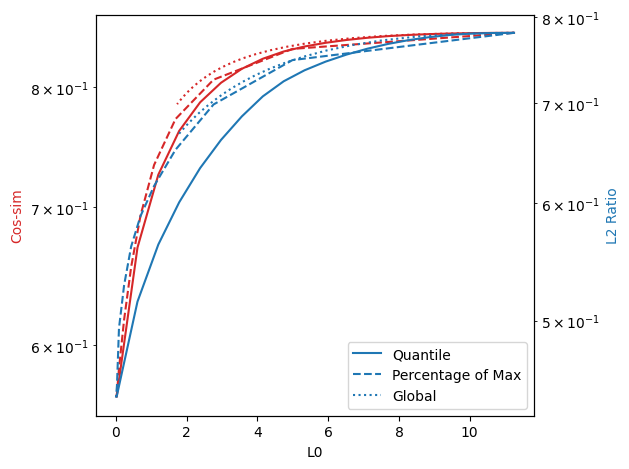

In [31]:
# Same for quantiles
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('L0')
ax1.set_ylabel('Cos-sim', color=color)
ax1.plot(avg_L0_quantile, avg_cos_sim_quantile, color=color, label="Quantile")
# ax1.plot(avg_L0_percentage, avg_cos_sim_percentage, color=color, label="Percentage")
# make above a dashed line
ax1.plot(avg_L0_percentage, avg_cos_sim_percentage, color=color, linestyle='dashed', label="Percentage of Max")
ax1.plot(avg_L0_linear, avg_cos_sim_linear, color=color, linestyle='dotted', label="Global")
# ax1.plot(avg_L0, avg_cos_sim, color=color, linestyle='dashdot', label="Lowest k-features")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('L2 Ratio', color=color)  # we already handled the x-label with ax1
ax2.plot(avg_L0_quantile, avg_l2_ratio_quantile, color=color, label="Quantile")
ax2.plot(avg_L0_percentage, avg_l2_ratio_percentage, color=color, linestyle='dashed', label="Percentage of Max")
ax2.plot(avg_L0_linear, avg_l2_ratio_linear, color=color, linestyle='dotted', label="Global")
# ax2.plot(avg_L0, avg_CE, color=color, linestyle='dashdot', label="Lowest k-features")
ax2.tick_params(axis='y', labelcolor=color)
# put y axis as log
ax1.set_yscale('log')
ax2.set_yscale('log')
plt.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [20]:
avg_L0_quantile, avg_CE_quantile, all_quantiles

(tensor([2.0464e+01, 2.0464e+01, 2.0464e+01, 2.0464e+01, 2.0464e+01, 2.0464e+01,
         2.0464e+01, 2.0464e+01, 2.0464e+01, 2.0464e+01, 2.0464e+01, 2.0464e+01,
         2.0464e+01, 2.0464e+01, 2.0464e+01, 2.0464e+01, 2.0290e+01, 1.9517e+01,
         1.7012e+01, 1.0742e-02]),
 tensor([ 5.8998,  5.8998,  5.8998,  5.8998,  5.8998,  5.8998,  5.8998,  5.8998,
          5.8998,  5.8998,  5.8998,  5.8998,  5.8998,  5.8998,  5.8998,  5.8998,
          5.8998,  5.9003,  5.9062, 10.3263]),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0385],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 3.3334]]))

In [158]:
avg_L0_quantile, avg_MSE_quantile, quantiles

(tensor([2.0684e+01, 2.0684e+01, 2.0684e+01, 2.0684e+01, 2.0684e+01, 2.0684e+01,
         2.0684e+01, 2.0684e+01, 2.0669e+01, 1.9620e+01, 1.0718e-02]),
 tensor([0.0738, 0.0738, 0.0738, 0.0738, 0.0738, 0.0738, 0.0738, 0.0738, 0.0738,
         0.0743, 0.5870]),
 tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.9718e-02, 3.2865e+00, 4.9305e+00, 6.3330e+00, 1.9502e+02]))

In [109]:
all_percentages[:, 1].max()

tensor(19.5023)

In [41]:
import torch

max_values = torch.tensor([10, 20, 5])  # Tensor of max values
max_len = max_values.max().item() + 1  # Find the maximum length for linspace tensors
indices = torch.arange(max_len).unsqueeze(0)  # Create a range tensor and add dimension for broadcasting

# Use broadcasting to compare indices with max_values, then multiply to get the linspace effect
percentages_list = [(indices <= max_val) * indices[:max_val+1] for max_val in max_values]

# 'percentages_list' now contains tensors with linearly spaced values from 0 to each max value
percentages_list

[tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0]]),
 tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
          18, 19, 20]]),
 tensor([[0, 1, 2, 3, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])]

In [ ]:
num_pos = 10
scale = 1
features_by_pos = [sae.encode(representation[:, (i*scale):(i*scale)+1, :].squeeze()) for i in range(num_pos)]
# Plot each as a hist in a new plot
import matplotlib.pyplot as plt
import numpy as np
for i in range(num_pos):
    # plot a new histogram
    plt.figure()
    zero_feature = features_by_pos[i].count_nonzero(-1)
    plt.hist(zero_feature.cpu().numpy(), bins=20, alpha=0.5, label=f"pos {i*scale}")
    # print(f"topk features num {zero_feature.topk(10)}")
plt.title("L0 at different token positions")
plt.legend()
plt.show()

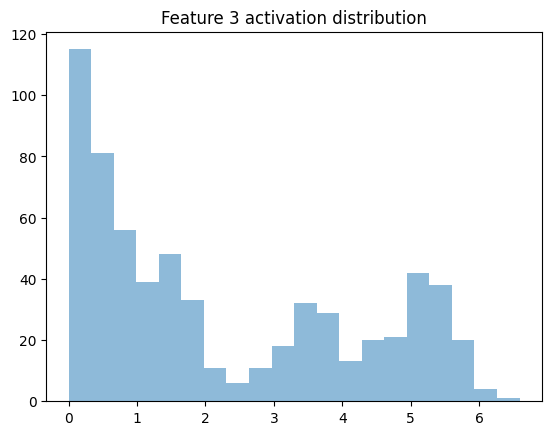

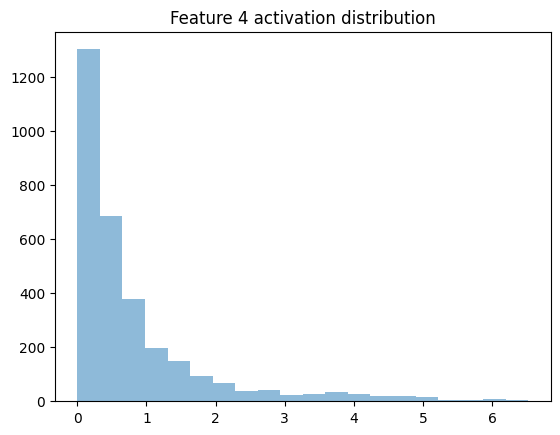

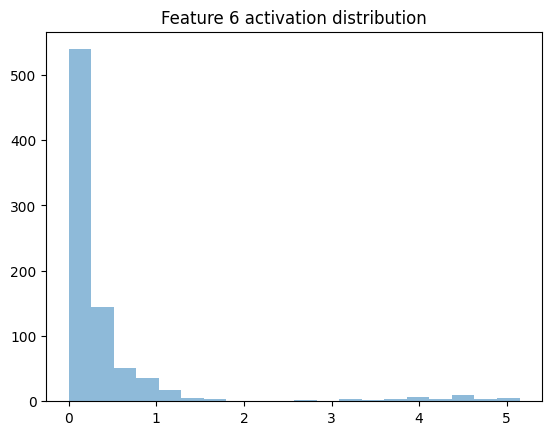

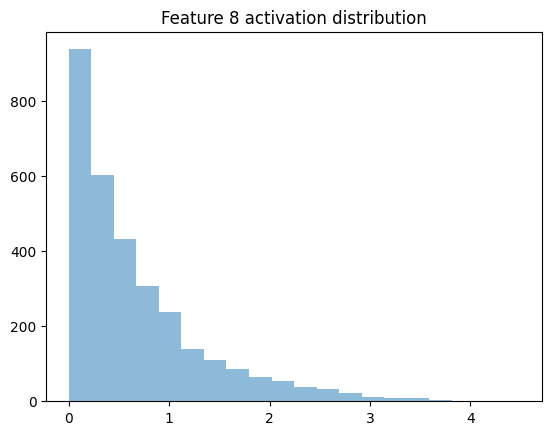

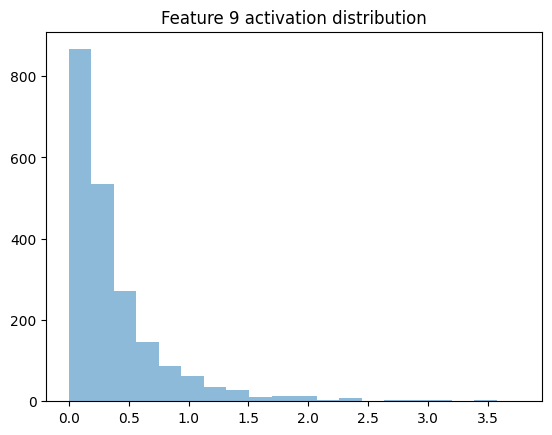

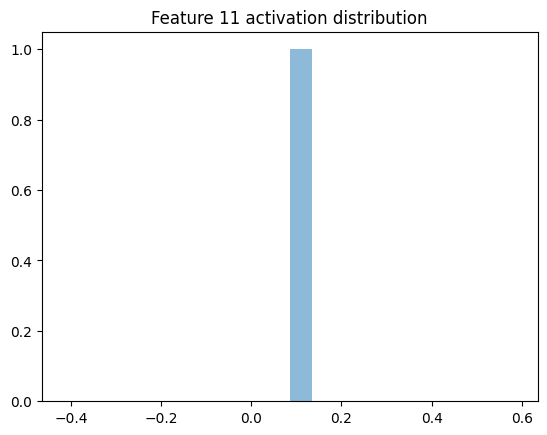

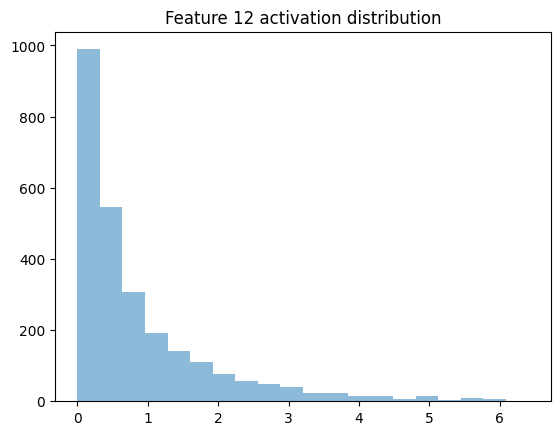

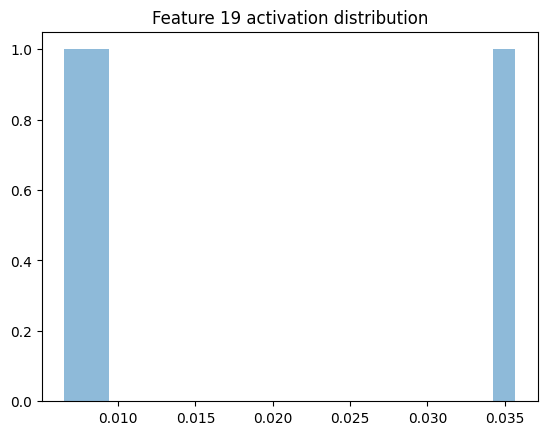

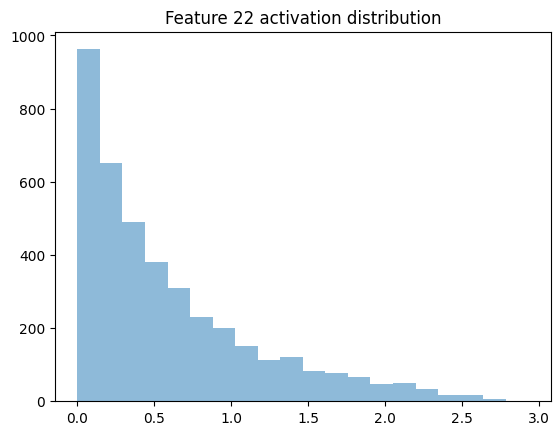

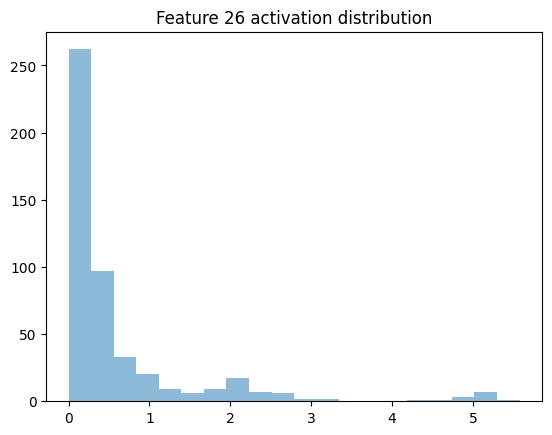

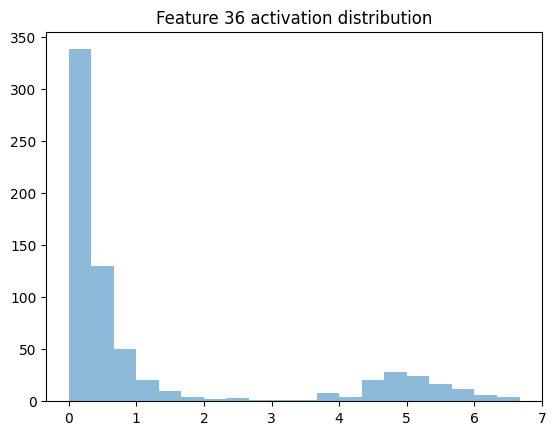

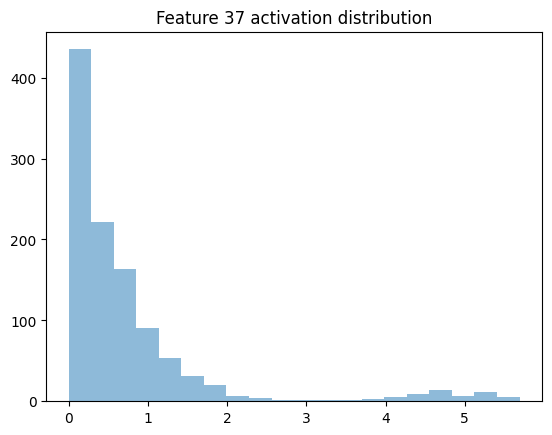

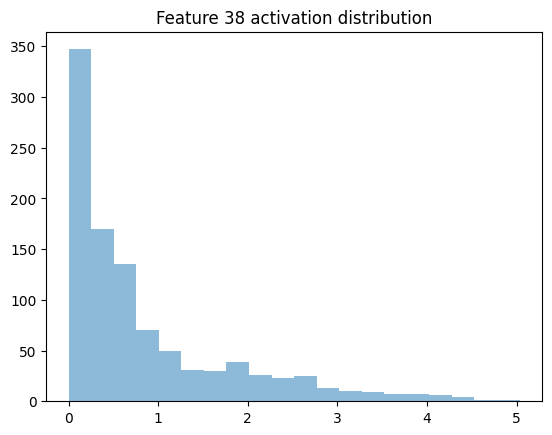

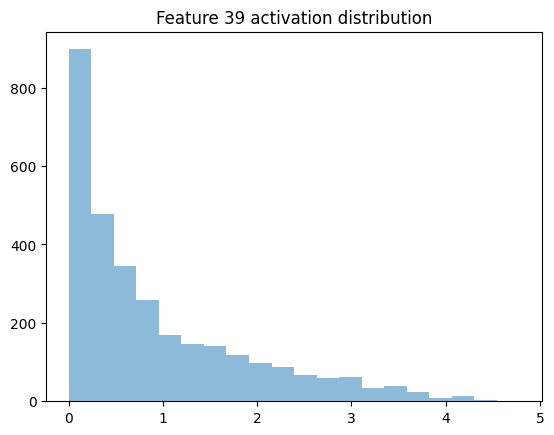

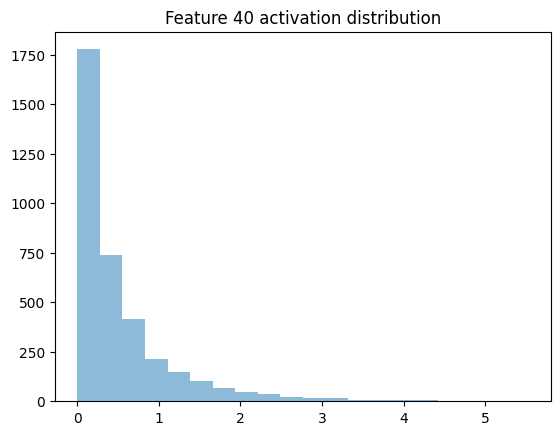

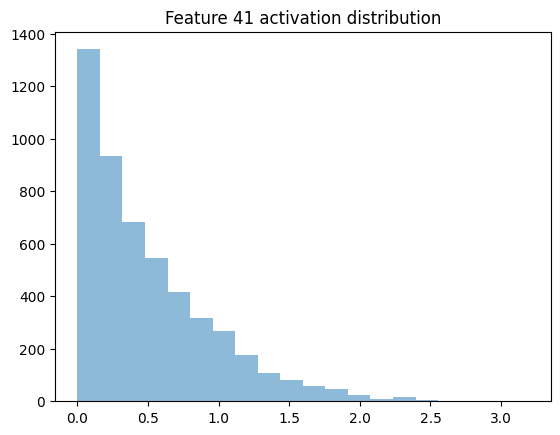

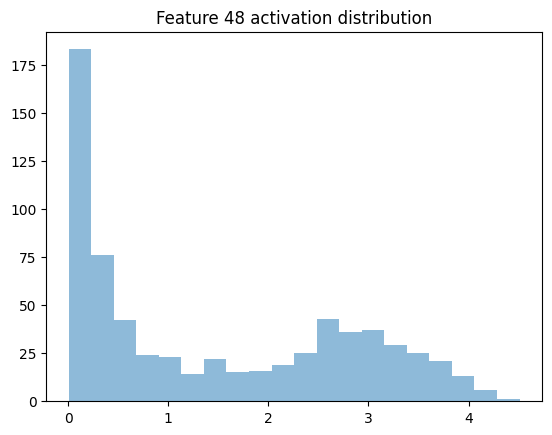

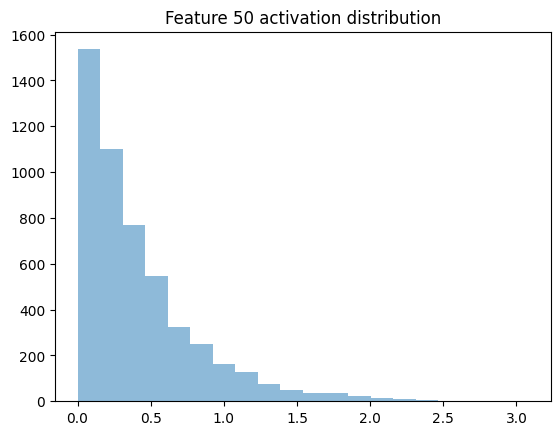

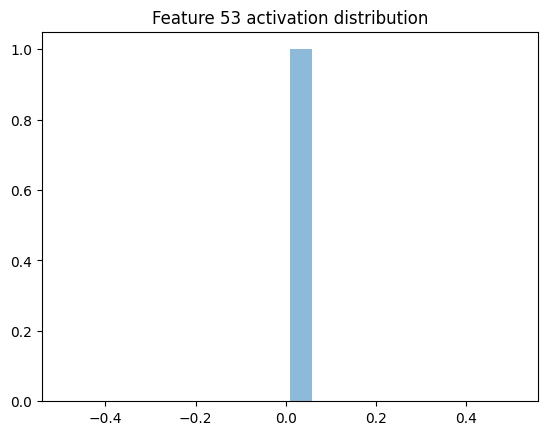

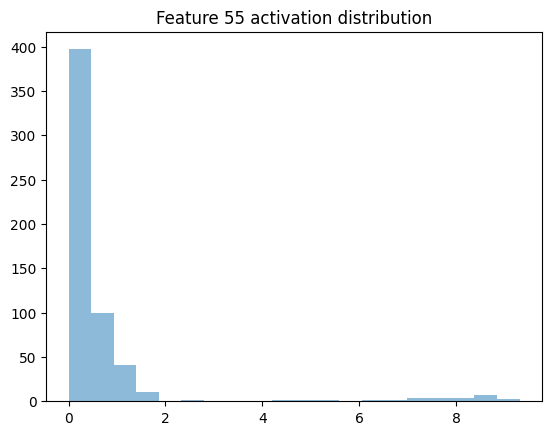

In [31]:
# Plot the dist of feature activation for first 10 features
# Find first M nonzero features
M = 20
nonzero_features = all_features.sum(0) > 0
# Find index of 
nz_ind = nonzero_features.nonzero()[:M, 0]
nonzero_features = all_features[:, nz_ind]
nonzero_features.shape
# Now plot their activations
for i in range(M):
    plt.figure()
    nz_datapoints = nonzero_features[:, i] > 0
    plt.hist(nonzero_features[nz_datapoints, i].cpu().numpy(), bins=20, alpha=0.5, label=f"feature {nz_ind[i]}")
    plt.title(f"Feature {nz_ind[i]} activation distribution")
plt.show()

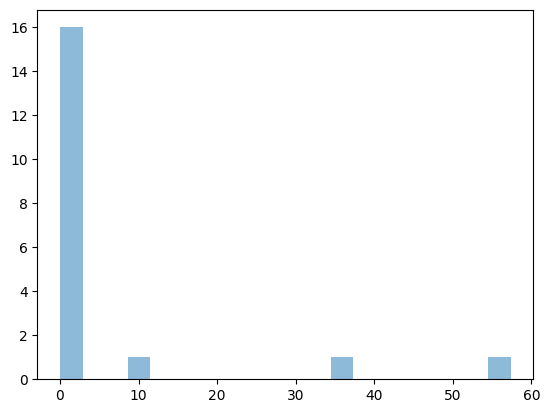

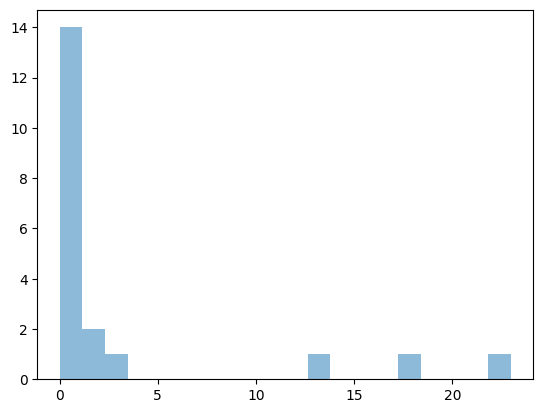

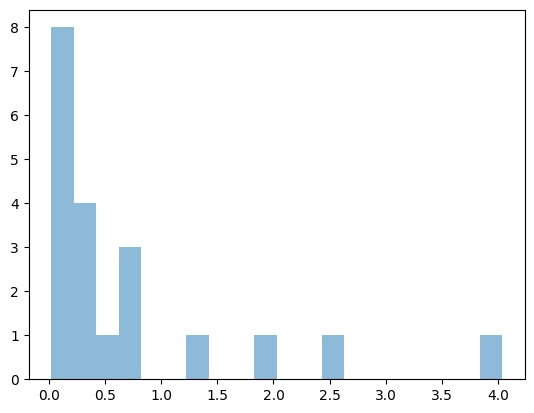

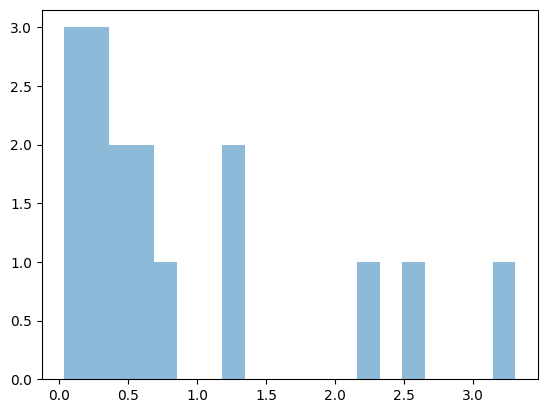

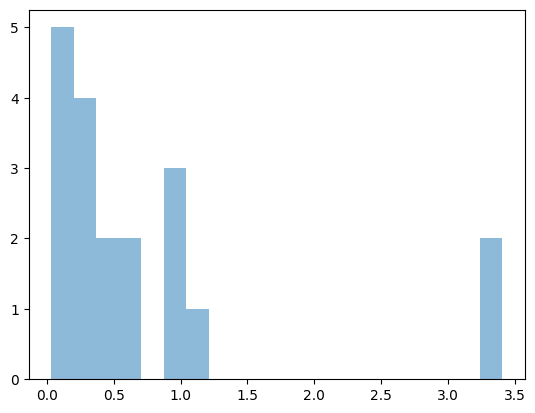

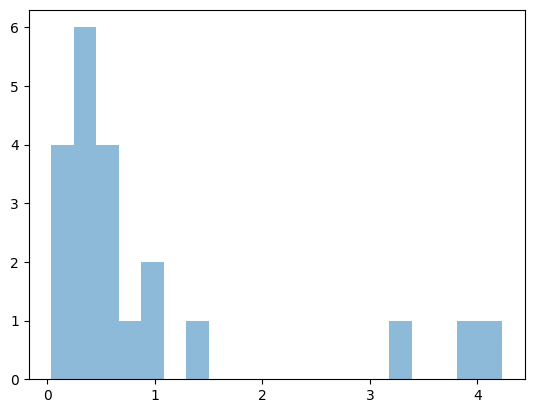

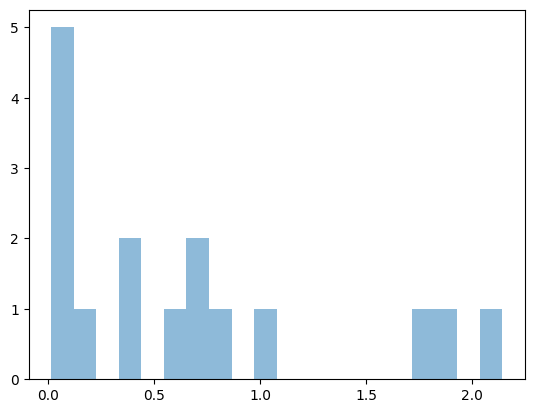

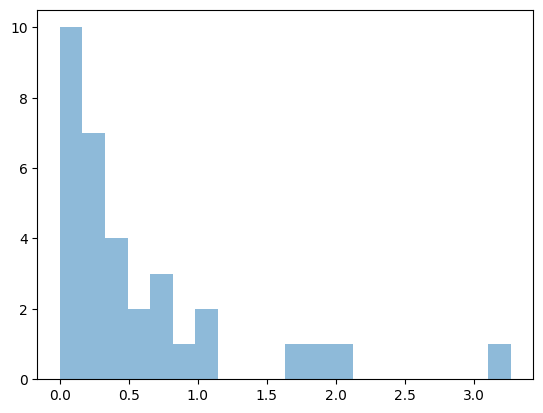

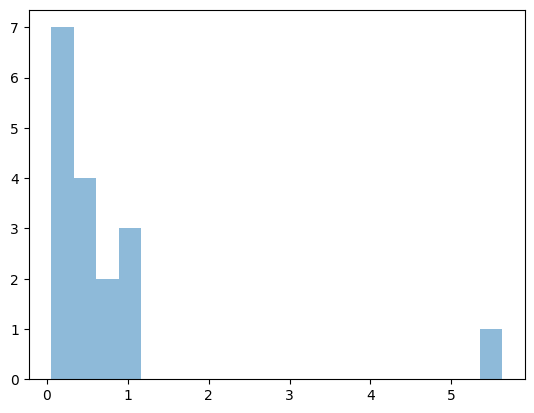

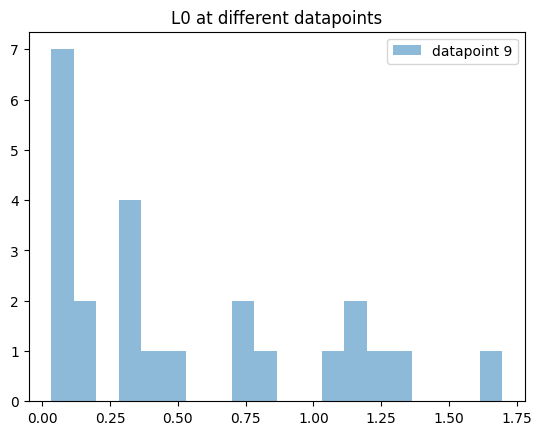

In [11]:
# Plot the hist of activations of the first 10 datapoints
features = sae.encode(activation)
for i in range(10):
    plt.figure()
    nonzero_feautres = features[i] > 0
    plt.hist(features[i][nonzero_feautres].cpu().numpy(), bins=20, alpha=0.5, label=f"datapoint {i}")
    # print(f"topk features num {zero_feature.topk(10)}")
plt.title("L0 at different datapoints")
plt.legend()

In [81]:
zero_feature, features_by_pos[i].shape

(tensor([ 9,  9,  9,  7,  8, 10,  8,  8,  8,  9,  8,  9,  9, 10,  8, 10],
        device='cuda:0'),
 torch.Size([16, 2048]))

In [ ]:
# get the k-lowest features per datapoint
k = 1
# shape is (batch, features)
d1 = features.count_nonzero(-1).cpu().numpy()
d1.sort()
# plot d1 as sorted line graph
import matplotlib.pyplot as plt
plt.hist(d1, bins=100)
plt.show()

In [71]:
d1[-30:]

array([106, 107, 111, 114, 115, 116, 117, 117, 120, 122, 124, 127, 127,
       130, 131, 132, 134, 134, 135, 136, 136, 137, 137, 137, 137, 138,
       140, 141, 204, 234])

In [57]:
d1.sort(), d1.sorted()

AttributeError: 'numpy.ndarray' object has no attribute 'sorted'

In [61]:
torch.norm(all_features, 0, dim=-1).median()

tensor(8.)

In [ ]:
with Trace(model, activation_name, edit_output=dict_ablation_fn) as ret:
    outputs = model(input_ids)
    logits_dict_reconstruction = outputs[0]